In [1]:
library(tidyverse)
theme_set(theme_classic(base_size=12))

Warning message:
"package 'tidyverse' was built under R version 3.6.2"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
Warning message:
"package 'tidyr' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()  masks stats::filter()
x purrr::flatten() masks jsonlite::flatten()
x dplyr::lag()     masks stats::lag()


## Exercice 1

On cherche à expliquer une variable binaire $Y$ par deux variables quantitatives $X_1$ et $X_2$ à l'aide du jeu de données suivant

In [2]:
n <- 2000
set.seed(12345)
X1 <- runif(n)
set.seed(5678)
X2 <- runif(n)
set.seed(9012)
R1 <- X1<=0.25
R2 <- (X1>0.25 & X2>=0.75)
R3 <- (X1>0.25 & X2<0.75)
Y <- rep(0,n)
Y[R1] <- rbinom(sum(R1),1,0.25)
Y[R2] <- rbinom(sum(R2),1,0.25)
Y[R3] <- rbinom(sum(R3),1,0.75)
donnees <- data.frame(X1,X2,Y)
donnees$Y <- as.factor(donnees$Y)
indapp <- 1:1500
dapp <- donnees[indapp,] # train set
dtest <- donnees[-indapp,] # test set

On remarque que $X$ suit une loi uniforme sur le carré $[0,1]^2$. $Y|X=x$ suit une loi de Bernoulli de paramètre
  * 0.25 si $x_1\leq 0.25$ ou $x_1>0.25$ et $x_2\geq 0.75$.
  * 0.75 sinon.
  
On déduit que la règle de Bayes est donnée par 

$$g^\star(x)=\left\{
\begin{array}{ll}
0 & \text{si }x_1\leq 0.25 \text{ ou }(x_1>0.25\text{ et }x_2\geq 0.75)\\
1 & \text{sinon.}
\end{array}\right.$$

L'erreur de Bayes vaut $L^\star=0.25$.

1. Représenter le nuage de points $X_2$ en fonction de $X_1$ en utilisant une couleur différente selon $Y$.

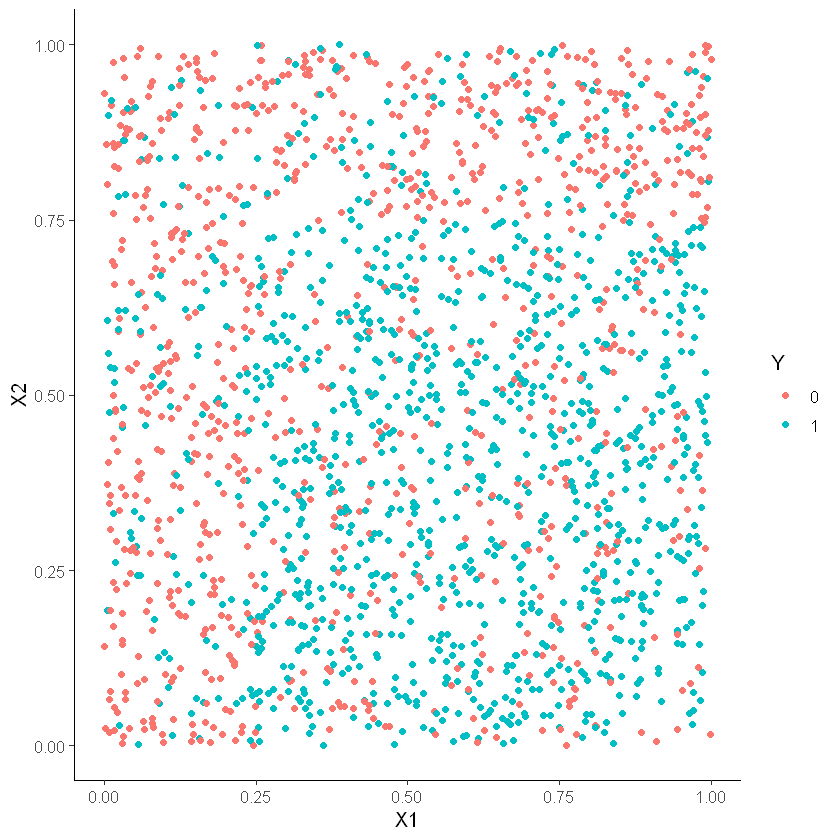

In [3]:
ggplot(donnees) +
aes(x = X1, y = X2, color = Y) +
geom_point()

2. Charger le package *class* et ajuster la règle des 3 plus proches voisins sur les données d'apprentissage (fonction **knn**). Estimer la probabilité d'erreur de cette règle en utilisant l'échantillon test.

In [4]:
library(class)

In [12]:
knn3 <- knn(dapp[,1:2], dtest[,1:2], cl=dapp$Y, k=3)
mean(knn3 != dtest$Y)

[1] 0.308

3. On souhaite maintenant choisir $k$ dans le vecteur `seq(1, 100, by = 2)`.  
Calculer, pour chaque valeur de 𝑘, l'erreur de classification avec la même technique que dans la question précédente. Quelle valeur de 𝑘 choisissez vous ?

In [29]:
k_cand <- seq(1,100,by=2)
grid <- data.frame(k = k_cand, error = rep(0, length(k_cand)))
for (k in k_cand){
    clf <- knn(dapp[,1:2], dtest[,1:2], cl=dapp$Y, k=k)
    error <- mean(clf != dtest$Y)
    grid[grid$k == k,] = c(k, error)    
}
grid  %>% 
filter(error == min(error))

k,error
27,0.216


4. On souhaite maintenant calculer l'erreur de la règle des 3 plus proches voisins avec de la validation croisée 10 blocs. Cette méthode nécessite de partitionner l'échantillon en 10 parties, on peut utiliser la fonction **createFolds** du package **caret**.

In [30]:
library(caret)
K <- 10
kfolds <- createFolds(1:nrow(donnees),k=K)

Warning message:
"package 'caret' was built under R version 3.6.2"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



On créé ensuite une fonction qui permet de calculer l'erreur pour une valeur de $k$ donnée :

In [31]:
err_cv <- function(k){
  erreur_bloc <- rep(0,K)
  for (j in 1:K){
    train <- donnees[kfolds[[j]],]
    test <- donnees[-kfolds[[j]],]
    prev <- knn(train[,1:2],test[,1:2],cl=train$Y,k=k)
    erreur_bloc[j] <- mean(prev!=test$Y)
  }
  return(mean(erreur_bloc))
}


Calculer, pour chaque valeur de $k$, l'erreur de classification avec cette technique de validation croisée. Quelle valeur de $k$ choisissez-vous ?

In [37]:
error <- rep(0, length(k_cand))
i <- 1
for (k in k_cand){
    error[i] <- err_cv(k)
    i <- i+1
}
paste("k:", k_cand[which.min(error)], "| error:", min(error))

[1] "k: 21 | error: 0.301055555555556"

## Exercice 2

On souhaite ici refaire le même travail que dans l'exercice précédent avec le package **caret**.

1. Expliquer les sorties des commandes suivantes

In [39]:
ctrl1 <- trainControl(method="LGOCV",number=1,index=list(1:1500))
KK <- data.frame(k=k_cand)
ee1 <- train(Y~.,data=donnees,method="knn",trControl=ctrl1,tuneGrid=KK)
ee1

k-Nearest Neighbors 

2000 samples
   2 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 1500 
Resampling results across tuning parameters:

  k   Accuracy  Kappa    
   1  0.620     0.2298338
   3  0.692     0.3797426
   5  0.710     0.4138098
   7  0.714     0.4200383
   9  0.722     0.4362610
  11  0.744     0.4789207
  13  0.744     0.4794801
  15  0.740     0.4713470
  17  0.744     0.4794801
  19  0.764     0.5191132
  21  0.772     0.5349141
  23  0.772     0.5344126
  25  0.772     0.5344126
  27  0.784     0.5589172
  29  0.776     0.5420871
  31  0.778     0.5469092
  33  0.776     0.5425808
  35  0.776     0.5420871
  37  0.778     0.5464204
  39  0.778     0.5459306
  41  0.778     0.5459306
  43  0.776     0.5415923
  45  0.778     0.5464204
  47  0.772     0.5334065
  49  0.770     0.5290591
  51  0.768     0.5252206
  53  0.768     0.5252206
  55  0.770     0.5290591
  57  0.768 

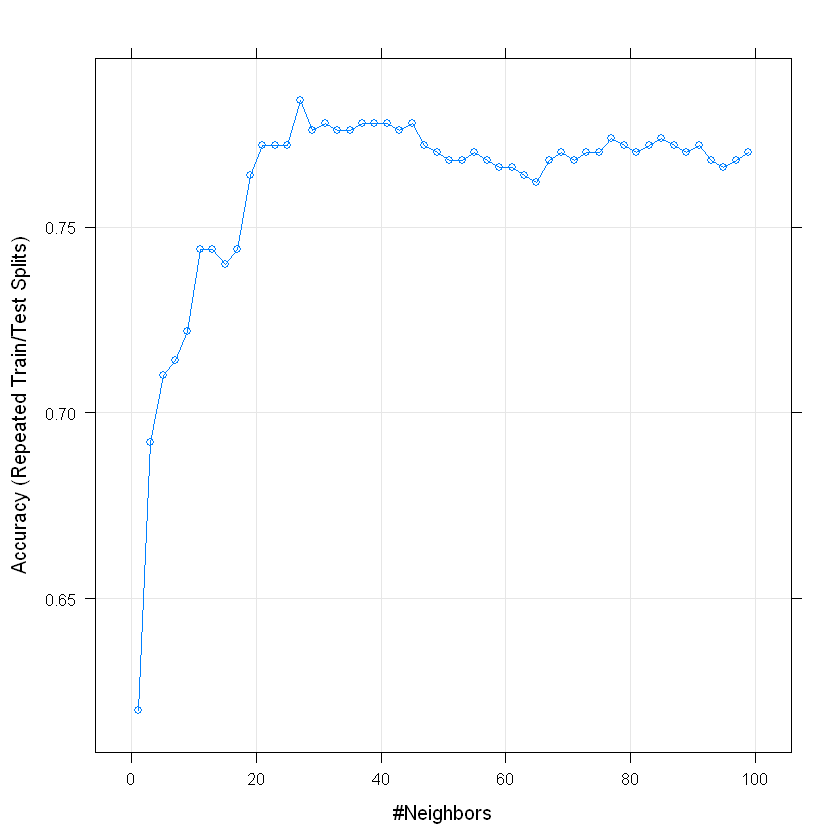

In [40]:
plot(ee1)

2. Utiliser **caret** pour sélectionner $k$ par validation croisée. On pourra regarder l'aide de la fonction **trainControl**.

In [46]:
ctrl2 <- trainControl(method = "repeatedcv", repeats = 2)
ee2 <- train(Y~.,data=donnees,method="knn",trControl=ctrl2,tuneGrid=KK)
ee2

k-Nearest Neighbors 

2000 samples
   2 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 2 times) 
Summary of sample sizes: 1800, 1800, 1800, 1800, 1800, 1800, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.6164960  0.2240709
   3  0.6774951  0.3460912
   5  0.6954914  0.3812728
   7  0.7154916  0.4217315
   9  0.7192491  0.4291574
  11  0.7207654  0.4320894
  13  0.7232604  0.4366715
  15  0.7297717  0.4499458
  17  0.7277692  0.4452289
  19  0.7287630  0.4468860
  21  0.7312581  0.4515334
  23  0.7302593  0.4492779
  25  0.7302630  0.4488723
  27  0.7317655  0.4518371
  29  0.7297618  0.4477437
  31  0.7335031  0.4554570
  33  0.7337531  0.4558317
  35  0.7352506  0.4591293
  37  0.7357506  0.4603846
  39  0.7354969  0.4598035
  41  0.7352456  0.4590834
  43  0.7332431  0.4549290
  45  0.7329931  0.4544951
  47  0.7329943  0.4544401
  49  0.7317493  0.4518451
  51  0.7325031  0.4533436
  53  0.7

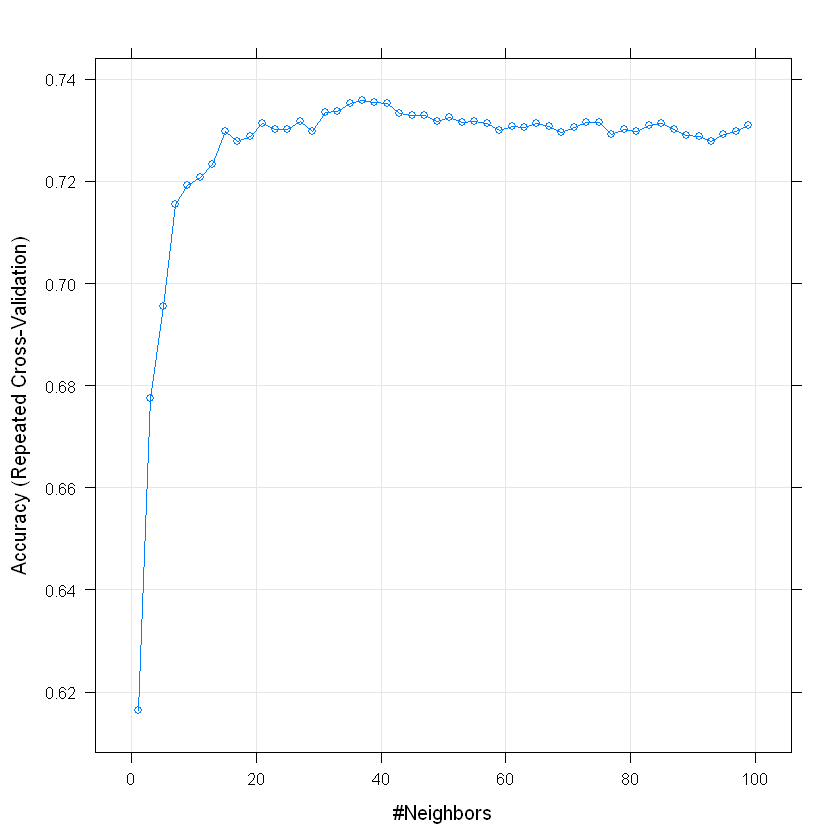

In [47]:
plot(ee2)

3. En utilisant l'option **index** dans **trainControl**, retrouver les résultats de l'exercice précédent pour la validation croisée 10 blocs.


**Remarque** : les algorithmes de validation croisée peuvent se révéler couteux en temps de calcul. Il est souvent pertinent d'utiliser des techniques de calcul parallèle pour ce type de méthode. La fonction train de caret permet de faire cela relativement simplement en utilisant des packages tels que **doMC** (pour mac) ou **doParallel** (pour win)

In [52]:
library(doParallel)
detectCores()

[1] 12

In [54]:
cl <- makePSOCKcluster(1)
registerDoParallel(cl)
system.time(eee <- train(Y~.,data=donnees,method="knn",trControl=ctrl2,tuneGrid=KK))
stopCluster(cl)

   user  system elapsed 
  16.27    0.00   16.30 

In [55]:
cl <- makePSOCKcluster(5)
registerDoParallel(cl)
system.time(eee <- train(Y~.,data=donnees,method="knn",trControl=ctrl2,tuneGrid=KK))
stopCluster(cl)

   user  system elapsed 
   1.49    0.05    8.64 

## Exercice 3

On considère 3 scores qui ont été calculés sur 100 individus. Le tableau suivant fournit les valeurs de score ainsi que les groupes observés pour chaque individu.

In [56]:
set.seed(1234)
S1 <- runif(100)
S2 <- runif(100)
S3 <- S1
S3[sample(100,25)] <- runif(25)
Y <- rep(0,n)
Y[S1>0.5] <- 1
df <- data.frame(S1,S2,S3,Y=as.factor(Y))

On peut visualiser les notes de score et les groupes avec

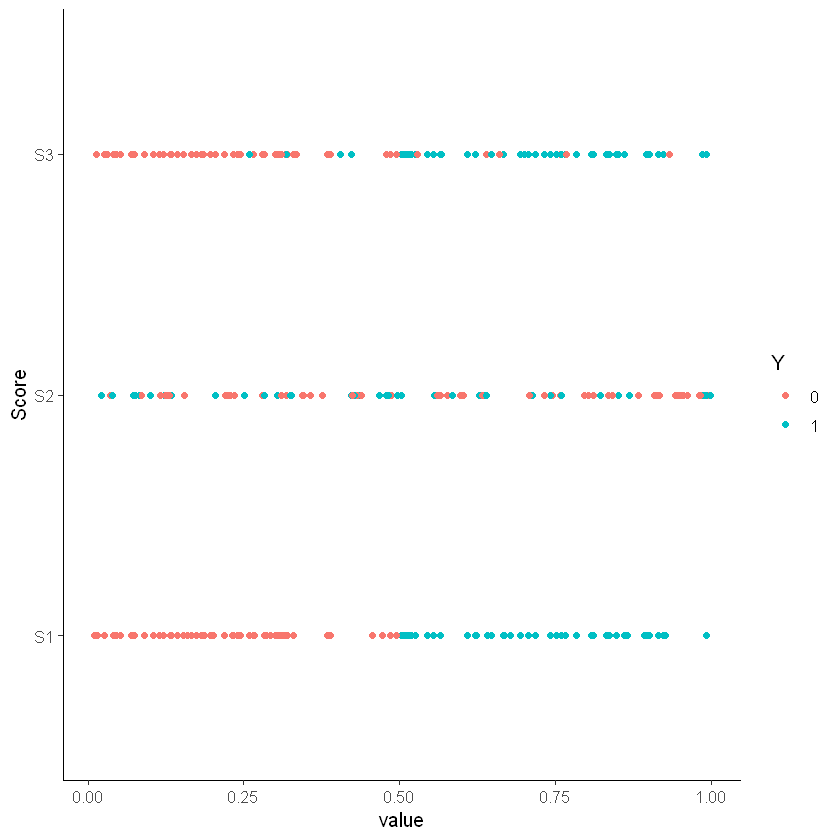

In [57]:
df1 <- df %>% gather(key="Score",value="value",-Y)
ggplot(df1)+aes(x=value,y=Score,color=Y)+geom_point()

1. Tracer la courbe ROC de $S_1$ avec la fonction **roc** du package **pROC**.

Setting levels: control = 0, case = 1
Setting direction: controls < cases


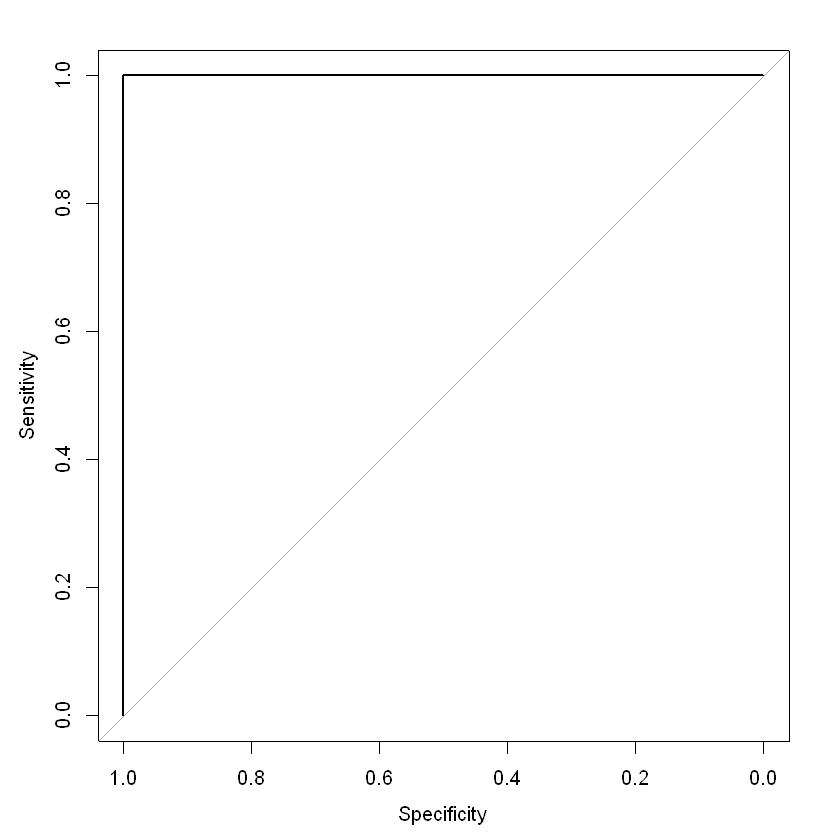

In [66]:
library(pROC)
plot(roc(df$Y, df$S1))

2. Ajouter les courbes ROC de $S_2$ et $S_3$. On pourra utiliser l'option **add=TRUE**.

In [67]:
plot(roc(df$Y, df$S2), add = T, col = "red")

Setting levels: control = 0, case = 1
Setting direction: controls > cases


ERROR: Error in plot.xy(xy.coords(x, y), type = type, ...): plot.new has not been called yet


3. Calculer les AUC des trois scores (fonction **auc**).

**Remarque** : on peut obtenir les courbes ROC et AUC en utilisant les outils du **tidyverse** (**ggplot** et **dplyr**).

In [ ]:
df1 <- df %>% gather(key="Score",value="value",-Y)
df1$Y <- df1$Y %>% as.numeric()-1
ggplot(df1)+aes(d=Y,m=value,color=Score)+geom_roc()

In [ ]:
df1 %>% group_by(Score) %>% summarize(AUC=auc(Y,value)) %>%
  arrange(desc(AUC)) %>% mutate(AUC=round(AUC,3))